In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys

from tqdm import tqdm
import pickle
import h5py

import numpy as np
from astropy.cosmology import Planck18
from astropy import units as u
from astropy import constants as const

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

In [16]:
def get_z_edges(z_max, z_min, zplusone_step_factor):
    z_s = [z_min]
    while z_s[-1] < z_max:
        z_s.append((z_s[-1] + 1.) * zplusone_step_factor - 1.)

    return np.clip(z_s[::-1], None, z_max)

In [17]:
z_edges = get_z_edges(45, 5, 1.001)
z_edges_coarse = get_z_edges(45, 5, 1.001**10)

In [21]:
z_match = z_edges_coarse[1]
z_edges = np.unique(np.clip(z_edges, None, z_match))[::-1]
z_edges_coarse = z_edges_coarse[1:]

In [32]:
z_edges

array([44.63820275, 44.63820275, 44.59261014, ...,  5.012006  ,
        5.006     ,  5.        ])

(43.0, 45.0)

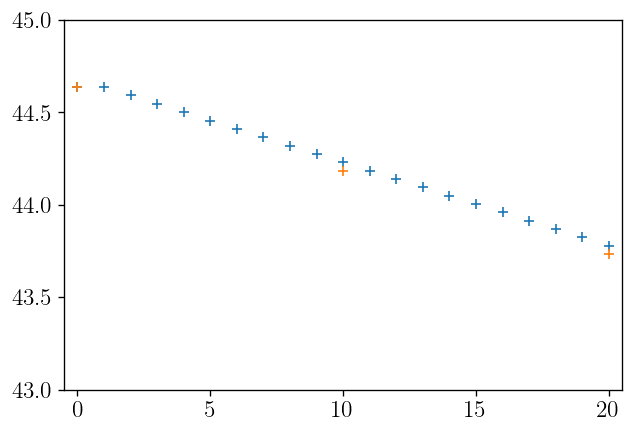

In [31]:
plt.plot(np.arange(len(z_edges)), z_edges, '+')
plt.plot(np.arange(0, 10*len(z_edges_coarse), 10), z_edges_coarse, '+')
plt.xlim(-0.5, 20.5)
plt.ylim(43, 45)

In [19]:
np.unique(get_z_edges(40, 1, 2**(1/3)) + 1)[::-1]

array([41.        , 40.3174736 , 32.        , 25.39841683, 20.1587368 ,
       16.        , 12.69920842, 10.0793684 ,  8.        ,  6.34960421,
        5.0396842 ,  4.        ,  3.1748021 ,  2.5198421 ,  2.        ])

In [20]:
get_z_edges(40, 1, 2) + 1

array([41., 32., 16.,  8.,  4.,  2.])

In [2]:
sys.path.append(os.environ['DM21CM_DIR'])
sys.path.append(os.environ['DM21CM_DIR'] + "/build_tf")
sys.path.append(os.environ['DH_DIR'])

In [8]:
from dm21cm.dm_params import DMParams
from dm21cm.utils import load_h5_dict

In [9]:
abscs = load_h5_dict(os.environ['DM21CM_DIR'] + '/data/abscissas/abscs_zf01.h5')

In [6]:
dmp = DMParams('decay', 'elec_delta', 1e8, lifetime=-1e26)

In [15]:
dmp.eng_per_inj

100000000.0

In [14]:
dir(dmp)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'eng_per_inj',
 'inj_elec_spec',
 'inj_phot_spec',
 'lifetime',
 'm_DM',
 'mode',
 'primary',
 'set_inj_specs',
 'sigmav',
 'struct_boost',
 'struct_boost_model']

In [13]:
dmp.inj_phot_spec.N

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [16]:
from scipy import interpolate

In [17]:
def debug_get_21totf_interp(fn):
    line_arr = []
    z_arr = []
    e_arr = []
    with open(fn, 'r') as f:
        for line in f:
            if "E_tot_ave = " in line:
                line_arr.append(line)
                tokens = line.split('E_tot_ave = ')
                e_arr.append(float(tokens[-1]))
                tokens = tokens[0].split('zp = ')
                z_arr.append(float(tokens[1]))

    # z_arr = np.array(z_arr)[1:]
    # e_arr = np.array(e_arr)[:-1]
    assert len(z_arr) == len(e_arr)
    return interpolate.interp1d(z_arr, e_arr, kind='linear', bounds_error=False, fill_value='extrapolate')

In [19]:
WDIR = os.environ['DM21CM_DIR']
interp = debug_get_21totf_interp(f"{WDIR}/outputs/stdout/xc_nopop2_noHe_nosp_noatten_esf.out")

In [20]:
interp(7.757164e+00)

array(0.00115426)

In [11]:
z_arr, e_arr = debug_get_21totf_interp("../scripts/xc_nopop2_noHe_nosp_noatten_esf.out")

[]

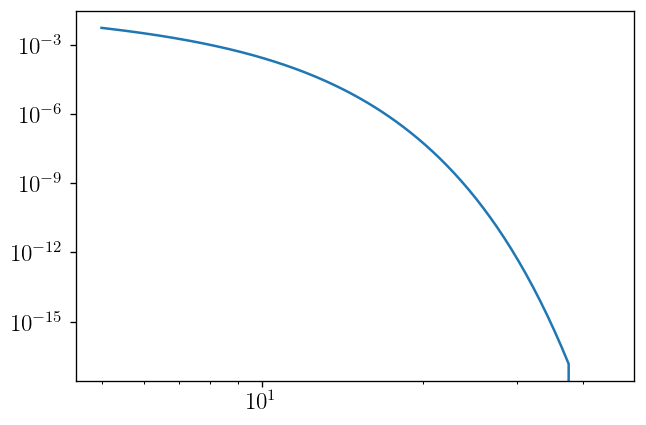

In [14]:
plt.plot(z_arr, e_arr)
plt.loglog()